In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from custom_classes import NasaDataset, SimpleAE, split_dataset, seed_everything, split_anomaly_normal
from ae_metrics import MAPE
from rul_metrics import RMSELoss
from normalisation import standard_scaling, min_max_scaling

import os

sns.set_style('whitegrid')

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [14]:
seed = 37

train_dataset = NasaDataset('../datasets/clean_train_data.csv')
train_dataset, anomaly_dataset = split_anomaly_normal(train_dataset)
seed_everything(seed)
train_dataset, test_dataset = split_dataset(train_dataset, test_size=0.1)
seed_everything(seed)
train_dataset, val_dataset = split_dataset(train_dataset, test_size=0.3)
# test_dataset = NasaDataset('../datasets/test.csv')

norm_func = min_max_scaling
try:
    norm_name = repr(norm_func).split(' ', maxsplit=2)[1]
except IndexError:
    norm_name = 'no_scaling'
for dtset in (train_dataset, val_dataset, test_dataset, anomaly_dataset):
    dtset.to(device)
    if norm_func:
        norm_func(dtset)

seed_everything(seed)
g = torch.Generator()
g.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
test_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
val_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
# test_loader = DataLoader(test_dataset, batch_size=..., shuffle=...)
print(f'Train: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}')
print(f'Anomaly: {len(anomaly_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (8, 4, 2)

seed_everything(seed)
model_ae = SimpleAE(input_shape, layers_sizes).to(device)
loss_func = nn.MSELoss()
metric_func = MAPE()
optimiser = optim.AdamW(model_ae.parameters(),
                       lr=1e-3)
optimiser_name = repr(optimiser).split(' ', maxsplit=1)[0]

Train: 5473
Validation: 1840
Test: 818
Anomaly: 12500


In [15]:
def plot_history(history_df: pd.DataFrame, ylabel: str = None, save_path: str = None):
    history_df = history_df.melt(ignore_index=False).iloc[1:]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    sns.lineplot(data=history_df,
                x=history_df.index,
                y='value',
                hue='variable')

    ax.set_ylabel(ylabel)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [16]:
def check_path(pth):
    if not os.path.exists(pth):
        os.makedirs(pth)
    return pth

In [17]:
try:
    if results: pass
except NameError:
    results = dict()

In [18]:
epochs = 100
history = list()

for epoch in range(epochs):
    train_losses = list()
    train_metrics = list()
    for dta in train_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)

        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
        train_metrics.append(metric.item())
    
    with torch.no_grad():
        val_losses = list()
        val_metrics = list()
        for dta in val_loader:
            sample = dta['sensors']
            sample = sample.to(device)
            _, reconstruction = model_ae(sample)

            loss = loss_func(reconstruction, sample)
            metric = metric_func(reconstruction, sample)

            val_losses.append(loss.item())
            val_metrics.append(metric.item())
    
    train_loss, val_loss = mean(train_losses), mean(val_losses)
    train_metrics, val_metrics = mean(train_metrics), mean(val_metrics)
    history.append((epoch, train_loss, val_loss, train_metrics, val_metrics))
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'{epoch+1:>3}/{epochs:>3}: {train_loss=:.4f}, {val_loss=:.4f}, {train_metrics=:.4f}%, {val_metrics=:.4f}%')

with torch.no_grad():
    test_losses = list()
    test_metrics = list()
    for dta in test_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)
        test_losses.append(loss.item())
        test_metrics.append(metric.item())
    test_loss = mean(test_losses)
    test_metrics = mean(test_metrics)
    print(f'\n{test_loss=:.4f}, {test_metrics=:.4f}%')


with torch.no_grad():
    anomaly_losses = list()
    anomaly_metrics = list()
    for dta in anomaly_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)
        anomaly_losses.append(loss.item())
        anomaly_metrics.append(metric.item())
    anomaly_loss = mean(anomaly_losses)
    anomaly_metric = mean(anomaly_metrics)
    print(f'\n{anomaly_loss=:.4f}, {anomaly_metric=:.4f}%')

results[norm_name] = (history, anomaly_losses, test_losses)

 10/100: train_loss=0.0218, val_loss=0.0208, train_metrics=inf%, val_metrics=inf%
 20/100: train_loss=0.0131, val_loss=0.0131, train_metrics=inf%, val_metrics=inf%
 30/100: train_loss=0.0124, val_loss=0.0123, train_metrics=inf%, val_metrics=inf%
 40/100: train_loss=0.0120, val_loss=0.0120, train_metrics=inf%, val_metrics=inf%
 50/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 60/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 70/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 80/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 90/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
100/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%

test_loss=0.0154, test_metrics=inf%

anomaly_loss=0.0201, anomaly_metric=inf%


In [20]:
def transform_values(values: tuple) -> tuple:
    columns = ('epoch', 'train_loss', 'val_loss', 'train_metric', 'val_metric')
    total_history_df = pd.DataFrame(values[0], columns=columns).set_index('epoch')

    history_df = total_history_df.loc[:,('train_loss', 'val_loss')].iloc[2:].melt(ignore_index=False)

    anomaly_losses_transfromed = np.array(values[1])[:600].reshape(-1, 6).mean(axis=1)[:-2]
    test_losses_transfromed = np.array(values[2])[:98]
    return history_df, anomaly_losses_transfromed, test_losses_transfromed


def plot_lines(ax: plt.Axes, history_df: pd.DataFrame, anomaly_losses: np.array,
               test_losses: np.array, title: str = None):
    sns.lineplot(data=history_df,
                x=history_df.index,
                y='value',
                hue='variable',
                ax=ax)

    ax.plot(anomaly_losses, color='k', label='anomaly_loss')
    ax.plot(test_losses, color='g', label='test_loss')
    ax.legend()
    ax.set_title(title)

    ax.set_ylabel('MSE')

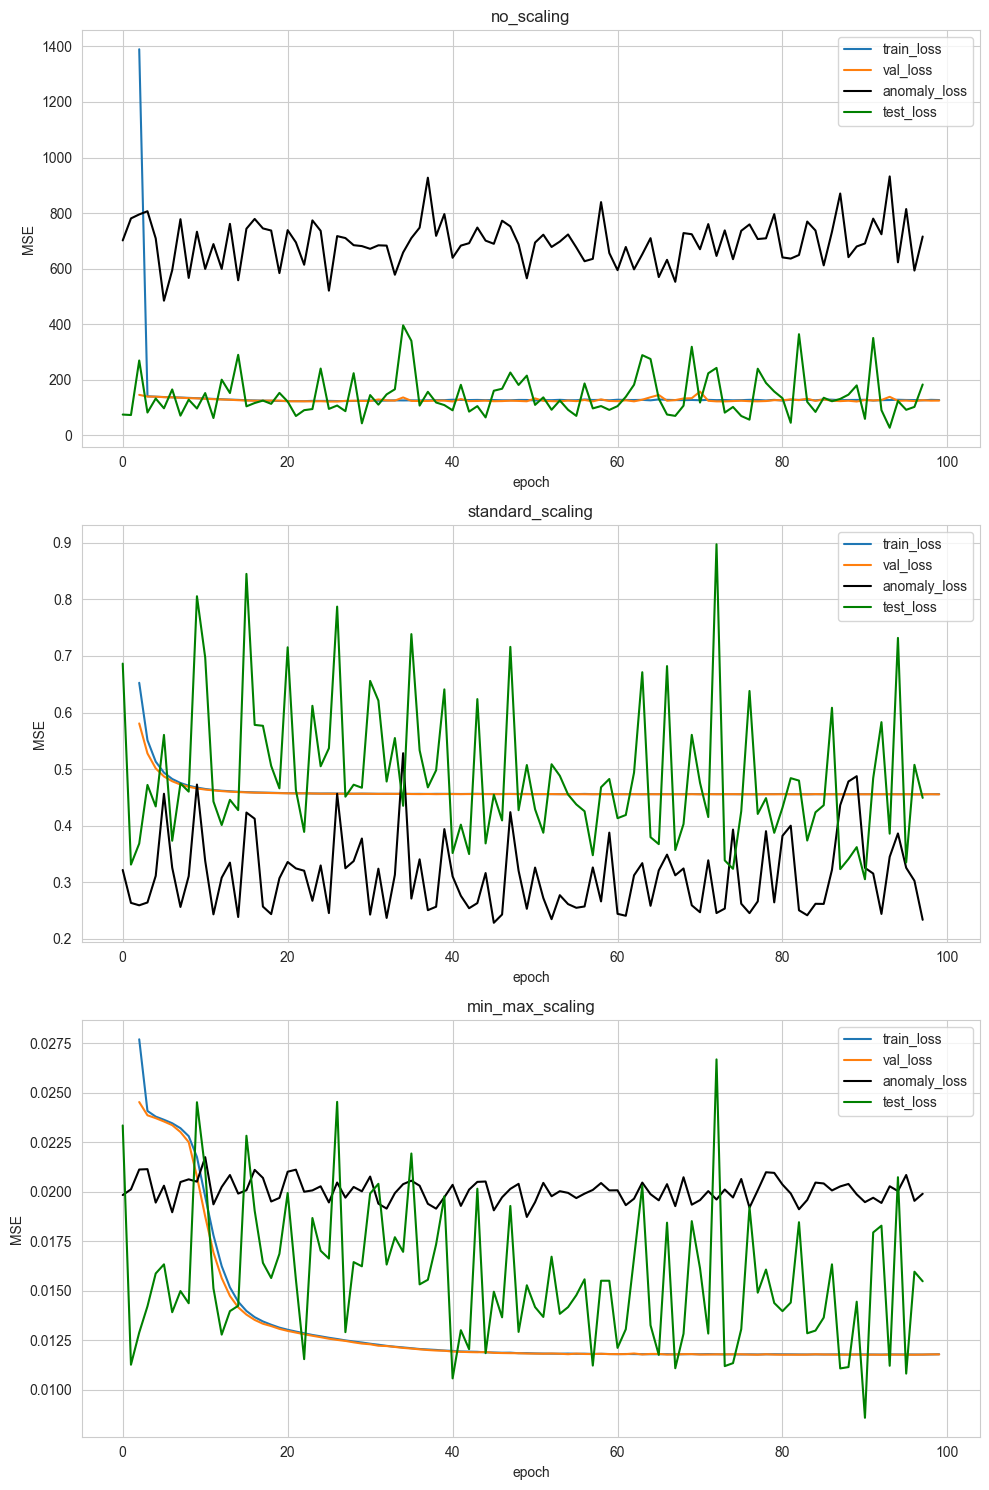

In [21]:
plt.close()
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(10, 15)

for ax, (title, values) in zip(axes.flatten(), results.items()):
    history_df, anomaly_losses_transfromed, test_losses_transfromed = transform_values(values)
    plot_lines(ax, history_df, anomaly_losses_transfromed, test_losses_transfromed, title=title)

plt.tight_layout()
# plt.savefig('../Plots/history/AdamW/norm-anom.png')
plt.show()

In [27]:
def transform_for_boxplots(values: tuple) -> pd.DataFrame:
    anomaly = pd.DataFrame([values[1], ['anomaly']*len(values[1])], index=('type', 'MSE')).T
    test = pd.DataFrame([values[2], ['normal']*len(values[2])], index=('type', 'MSE')).T
    return pd.concat((anomaly, test), axis=0, ignore_index=True)


def plot_boxplot(ax: plt.Axes, df: pd.DataFrame, title: str = None):
    sns.boxplot(data=df,
                y='type',
                x='MSE',
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel(None)

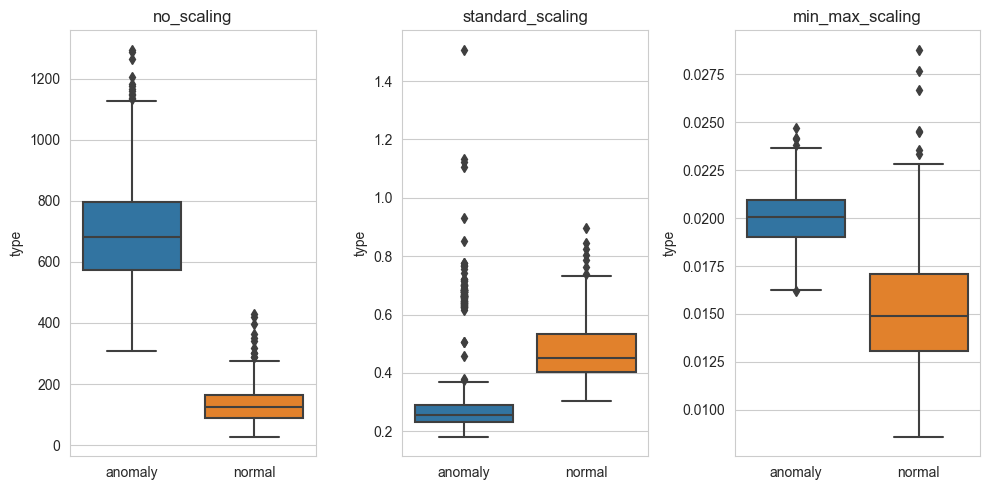

In [30]:
plt.close()
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(10, 5)

for ax, (title, values) in zip(axes.flatten(), results.items()):
    df = transform_for_boxplots(values)
    plot_boxplot(ax, df, title)

plt.tight_layout()
plt.show()